# Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)
import pandas as pd
import h5py
import math
import logging

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

from keras.utils import Sequence

2.15.0


In [ ]:
import pandas as pd
import pyarrow.parquet as pq
import pyarrow
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.model_selection import train_test_split

#Data loader

In [ ]:
class CustomDataLoader(Sequence):
    def __init__(self, file_path, indices, batch_size, mean, std):
        self.file_path = file_path
        self.indices = indices
        self.batch_size = batch_size
        self.parquet_file = pq.ParquetFile(file_path)
        self.columns = ["X_jets","y"]
        self.on_epoch_end()
        self.mean = mean
        self.std = std

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, len(self.indices))
        batch_indices = self.indices[start_idx:end_idx]

        # Load data from parquet file based on batch indices
        imgs,labels = self.load_data(batch_indices)

        # Preprocess data
        imgs = self.process_data(imgs)

        return imgs, labels

    def load_data(self, batch_indices):

        tables = []
        # Read the specified row groups from the Parquet file
        for row_group in batch_indices:
          table_chunk = self.parquet_file.read_row_group(row_group)
          tables.append(table_chunk)

        # Concatenate tables into a single table
        table = pyarrow.concat_tables(tables)

        # Convert the table to a Pandas DataFrame
        dataset = table.to_pandas()

        images_raw = dataset["X_jets"].to_numpy()
        labels = dataset["y"].to_numpy().astype(np.int64)

        imgs = np.empty([0,125,125,3],dtype=np.float32)
        for inx,img in enumerate(images_raw):
          img_np = np.stack([np.stack(channel) for channel in img])
          # change the shape to (125,125,3)
          img_np = img_np.transpose()
          imgs = np.vstack((imgs,np.expand_dims(img_np,axis=0)))


        return imgs,labels

    def process_data(self, data):

        # Perform additional preprocessing if needed

        return (data - self.mean) / self.std

    def on_epoch_end(self):
        # Shuffle indices at the end of each epoch
        np.random.shuffle(self.indices)

file_path = 'QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet'

indices = np.arange(36272)
np.random.shuffle(indices)
train_idx = indices[:int(len(indices)*0.8)]
val_idx = indices[int(len(indices)*0.8):]
batch_size = 64

mean_train = np.load('mean_train2.npy')
std_train = np.load('std_train2.npy')

train_generator = CustomDataLoader(file_path, train_idx, batch_size, mean_train, std_train)
val_generator = CustomDataLoader(file_path, val_idx, batch_size, mean_train, std_train)

In [ ]:
imgs, labels = train_generator.__getitem__(0)

In [ ]:
imgs.shape, labels.shape

((64, 125, 125, 3), (64,))

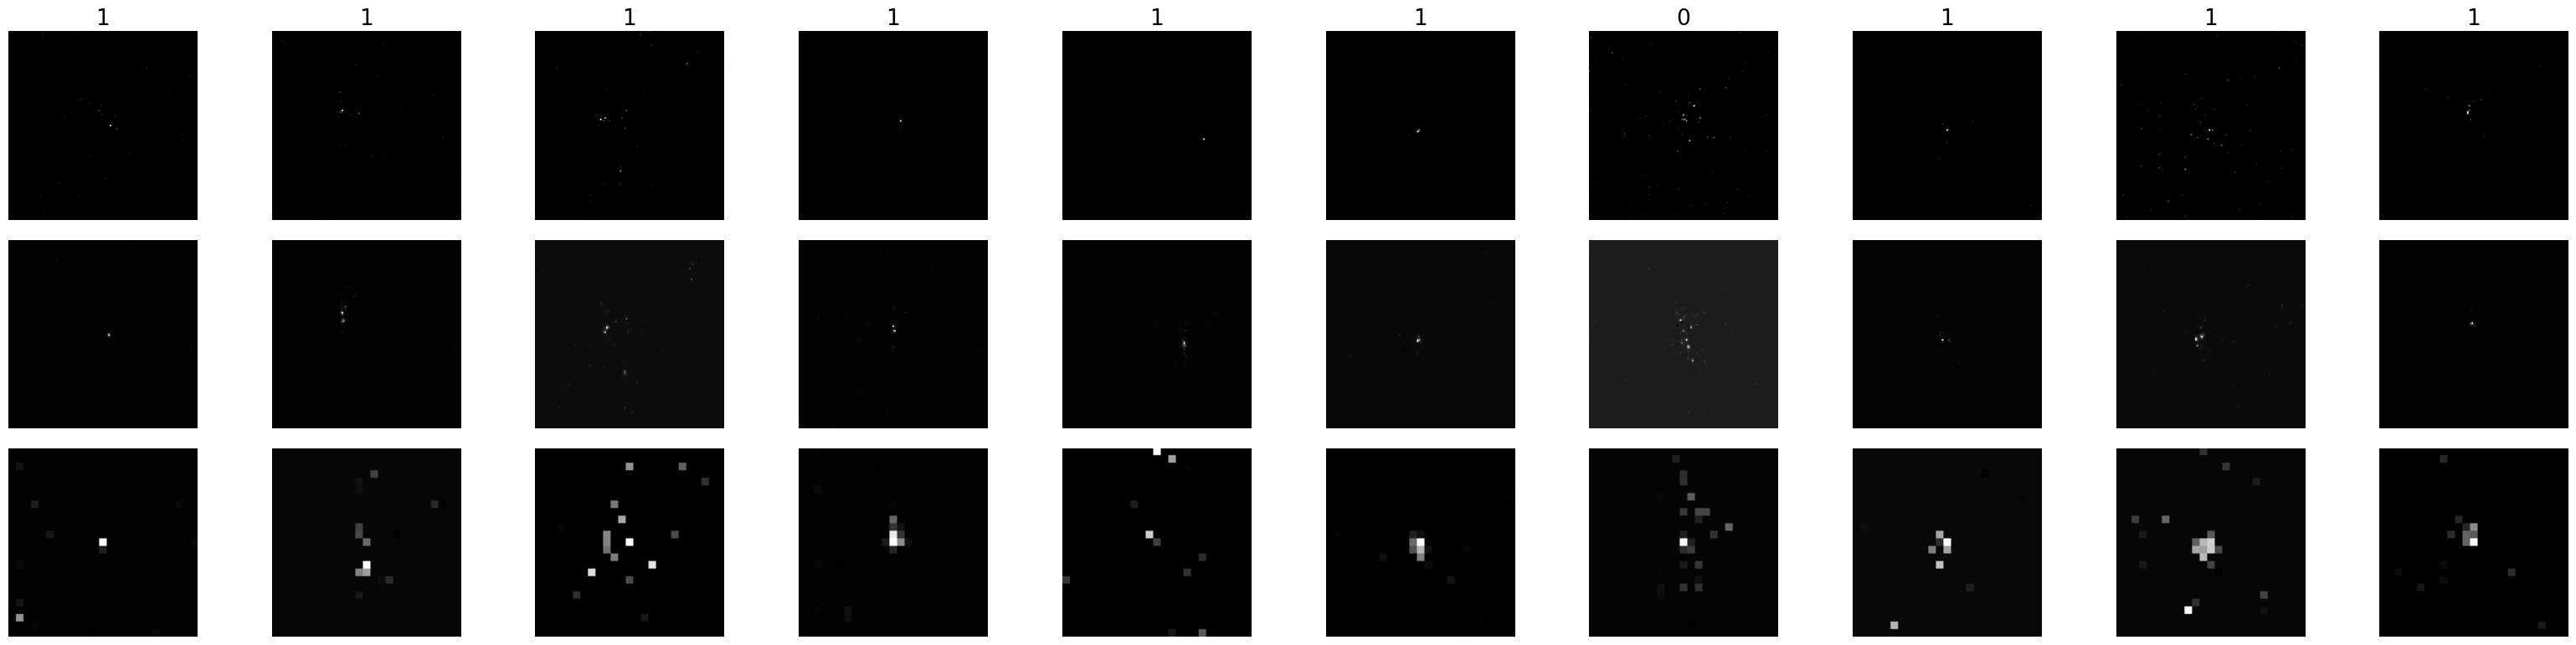

In [ ]:
# Display a sample of images from the training-validation dataset
# Each sample is made up of three channels
num_img = 10
idxs = np.random.randint(0, len(labels), size=(num_img,))
fig, axes = plt.subplots(3, num_img, figsize=(32, 8))

# Iterate through the selected number of samples
for i in range(num_img):
    ax0 = axes[0][i]
    ax0.imshow(imgs[idxs[i]][:,:,0],cmap='gray')
    ax0.axis('off')

    ax1 = axes[1][i]
    ax1.imshow(imgs[idxs[i]][:,:,1],cmap='gray')
    ax1.axis('off')

    ax2 = axes[2][i]
    ax2.imshow(imgs[idxs[i]][:,:,2],cmap='gray')
    ax2.axis('off')

    ax0.set_title('{}'.format(labels[idxs[i]]))


# Adjust layout and display the images
plt.tight_layout()
plt.show()

# VGG

VGG model made up of 12 convolutional layers and a dense layer after a GAP. After each convolution there is group normalization layer and a ReLU activation faction. Group normalization is preferred over the batch normalization due to the low batch size used during training. Dropout with a rate of 0.1 is used to reduce overfitting.

In [ ]:
def get_VGG_model(input_shape=(125,125,3),rate=0.1):

  input_layer = tfk.Input(shape=input_shape)

  x = tfkl.Conv2D(8,7,padding='valid', strides= 1)(input_layer)
  x = tfkl.GroupNormalization(groups=4)(x)
  x = tfkl.Activation('relu')(x)
  x = tfkl.Conv2D(8,7,padding='valid', strides= 1)(x)
  x = tfkl.GroupNormalization(groups=4)(x)
  x = tfkl.Activation('relu')(x)
  x = tfkl.Dropout(rate)(x)

  x = tfkl.Conv2D(16,3,padding='same')(x)
  x = tfkl.GroupNormalization(groups=8)(x)
  x = tfkl.Activation('relu')(x)
  x = tfkl.Conv2D(16,3,padding='same')(x)
  x = tfkl.GroupNormalization(groups=8)(x)
  x = tfkl.Activation('relu')(x)
  x = tfkl.MaxPool2D()(x)
  x = tfkl.Dropout(rate)(x)

  x = tfkl.Conv2D(32,3,padding='same')(x)
  x = tfkl.GroupNormalization(groups=8)(x)
  x = tfkl.Activation('relu')(x)
  x = tfkl.Conv2D(32,3,padding='same')(x)
  x = tfkl.GroupNormalization(groups=8)(x)
  x = tfkl.Activation('relu')(x)
  x = tfkl.MaxPool2D()(x)
  x = tfkl.Dropout(rate)(x)

  x = tfkl.Conv2D(64,3,padding='same')(x)
  x = tfkl.GroupNormalization(groups=32)(x)
  x = tfkl.Activation('relu')(x)
  x = tfkl.Conv2D(64,3,padding='same')(x)
  x = tfkl.GroupNormalization(groups=32)(x)
  x = tfkl.Activation('relu')(x)
  x = tfkl.MaxPool2D()(x)
  x = tfkl.Dropout(rate)(x)

  x = tfkl.Conv2D(128,3,padding='same')(x)
  x = tfkl.GroupNormalization(groups=32)(x)
  x = tfkl.Activation('relu')(x)
  x = tfkl.Conv2D(128,3,padding='same')(x)
  x = tfkl.GroupNormalization(groups=32)(x)
  x = tfkl.Activation('relu')(x)
  x = tfkl.MaxPool2D()(x)
  x = tfkl.Dropout(rate)(x)

  x = tfkl.Conv2D(256,3,padding='same')(x)
  x = tfkl.GroupNormalization(groups=32)(x)
  x = tfkl.Activation('relu')(x)
  x = tfkl.Conv2D(256,3,padding='same')(x)
  x = tfkl.GroupNormalization(groups=32)(x)
  x = tfkl.Activation('relu')(x)

  x = tfkl.GlobalAvgPool2D()(x)
  x = tfkl.Dropout(rate)(x)
  output_layer = tfkl.Dense(1,activation='sigmoid')(x)

  model = tfk.Model(inputs=input_layer, outputs=output_layer)

  return model

In [ ]:
model = get_VGG_model()

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 125, 125, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 119, 119, 8)       1184      
                                                                 
 group_normalization_12 (Gr  (None, 119, 119, 8)       16        
 oupNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 119, 119, 8)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 113, 113, 8)       3144      
                                                                 
 group_normalization_13 (Gr  (None, 113, 113, 8)       16        
 oupNormalization)                                         

In [ ]:
batch_size = 64
epochs = 20

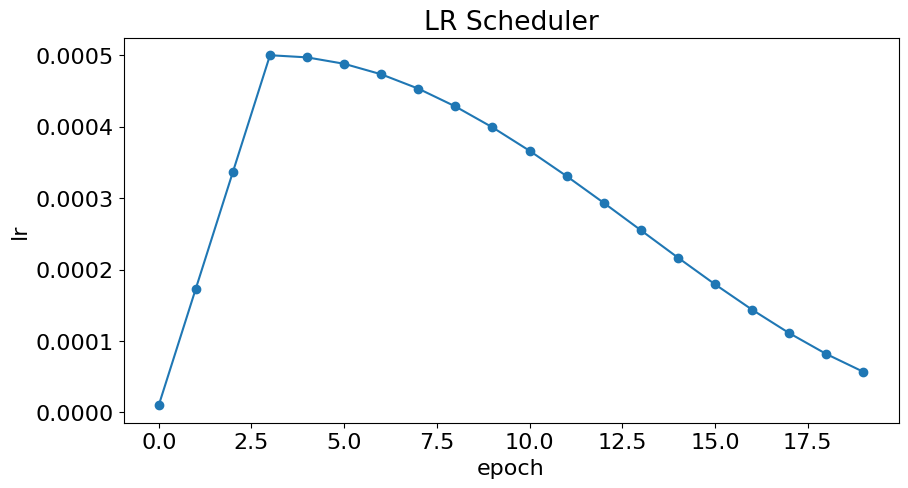

In [ ]:
def get_lr_callback(batch_size=32, mode='cos', epochs=50, plot=False):
    lr_start, lr_max, lr_min = 1e-5, 5e-4, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return tfk.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

lr_cb = get_lr_callback(batch_size, mode='cos', epochs=epochs, plot=True)
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=4, restore_best_weights=True)
callbacks = [early_stopping, lr_cb]

In [ ]:
# Define optimizer and metrics
learning_rate = 1e-5
optimizer = tfk.optimizers.AdamW(learning_rate)
loss = tfk.losses.BinaryCrossentropy()
metrics = ['accuracy','AUC']

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = callbacks
).history

Epoch 1/20
454/454 [==============================] - 200s 413ms/step - loss: 0.6194 - accuracy: 0.6596 - auc: 0.7185 - val_loss: 0.5998 - val_accuracy: 0.6965 - val_auc: 0.7711 - lr: 1.0000e-05
Epoch 2/20
454/454 [==============================] - 178s 393ms/step - loss: 0.5949 - accuracy: 0.6911 - auc: 0.7492 - val_loss: 0.5685 - val_accuracy: 0.7185 - val_auc: 0.7829 - lr: 1.7333e-04
Epoch 3/20
454/454 [==============================] - 182s 402ms/step - loss: 0.5804 - accuracy: 0.7054 - auc: 0.7649 - val_loss: 0.5732 - val_accuracy: 0.7118 - val_auc: 0.7876 - lr: 3.3667e-04
Epoch 4/20
454/454 [==============================] - 187s 411ms/step - loss: 0.5685 - accuracy: 0.7155 - auc: 0.7773 - val_loss: 0.5575 - val_accuracy: 0.7257 - val_auc: 0.7902 - lr: 5.0000e-04
Epoch 5/20
454/454 [==============================] - 194s 428ms/step - loss: 0.5625 - accuracy: 0.7202 - auc: 0.7833 - val_loss: 0.5585 - val_accuracy: 0.7268 - val_auc: 0.7909 - lr: 4.9698e-04
Epoch 6/20
454/454 [=====

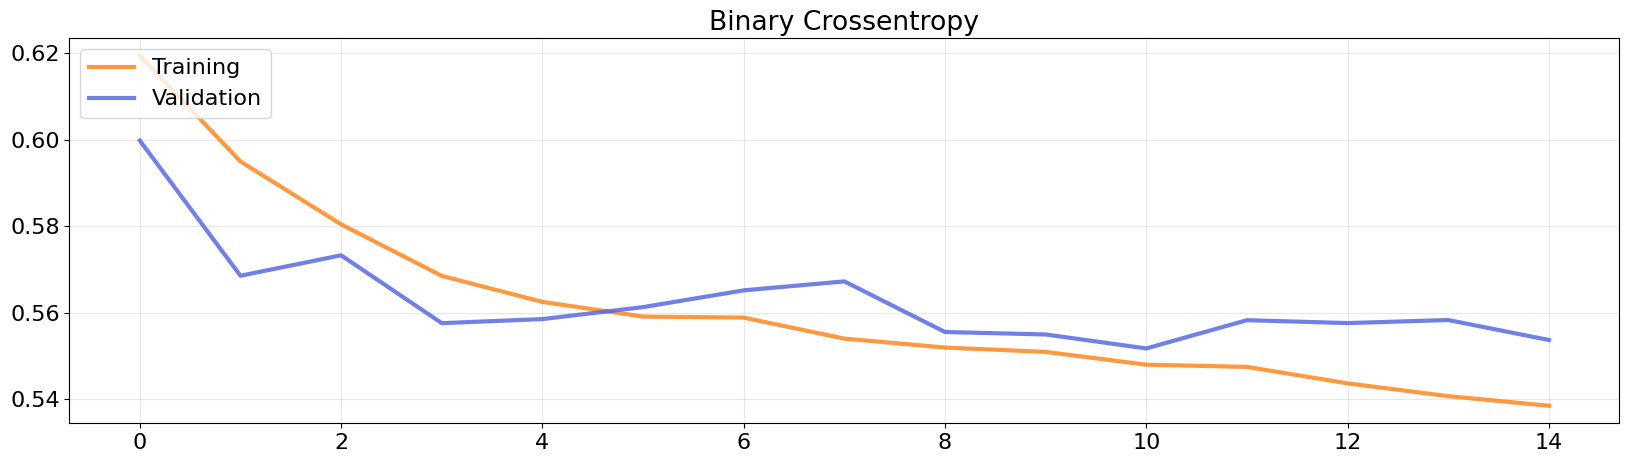

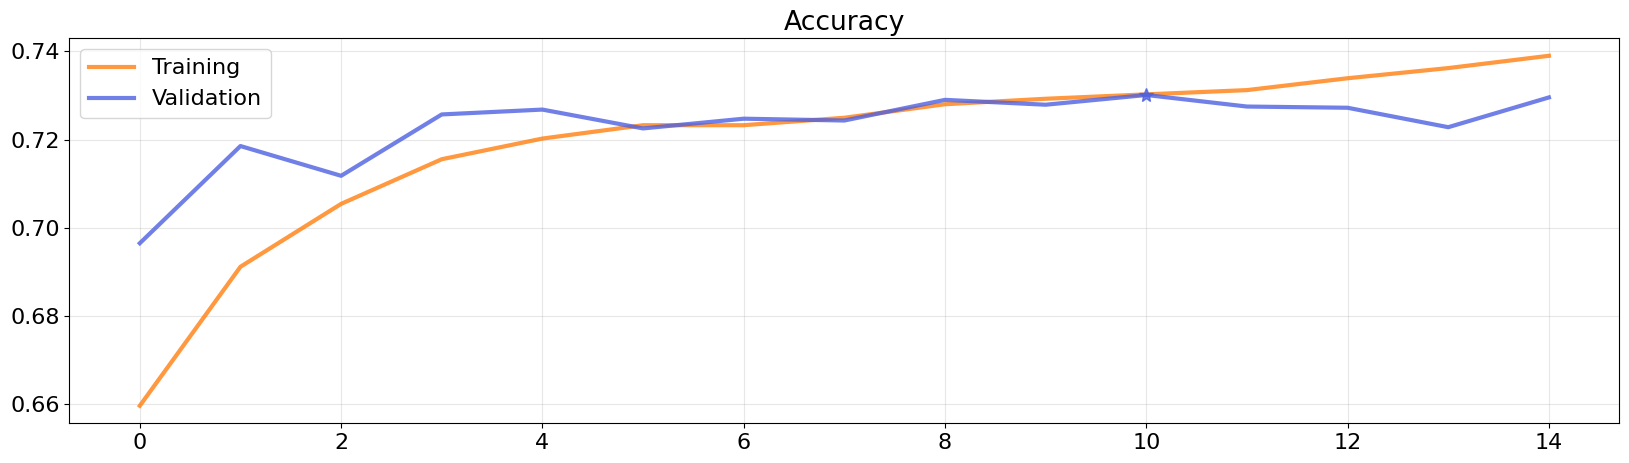

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
save = False

if save:
  model.save('VGG')

In [ ]:
file_path = 'QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet'
test_generator = CustomDataLoader(file_path, val_idx, batch_size, mean_train, std_train)

In [ ]:
out = model.evaluate(test_generator,steps=len(test_generator))

114/114 [==============================] - 35s 304ms/step - loss: 0.5400 - accuracy: 0.7362 - auc: 0.8045


In [ ]:
del model
del history

# ResNet

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_net_6 (ResNet)          (4, 7, 7, 512)            1652704   
                                                                 
 global_average_pooling2d_5  (4, 512)                  0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_32 (Dropout)        (4, 512)                  0         
                                                                 
 dense_5 (Dense)             (4, 256)                  131328    
                                                                 
 dropout_33 (Dropout)        (4, 256)                  0         
                                                                 
 dense_6 (Dense)             (4, 1)                    257       
                                                     

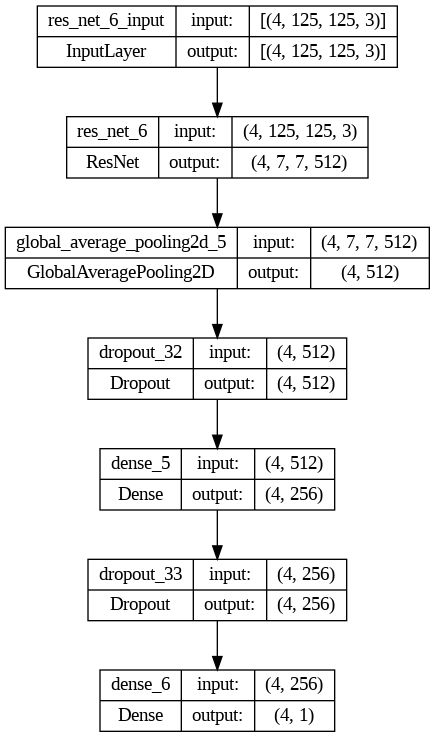

In [ ]:
class ResNetBlock(tfkl.Layer):
    def __init__(self, filters1, filters2, groups=32, downsample=True, use_norm=True, activation='relu', **kwargs):
        super(ResNetBlock, self).__init__(**kwargs)

        self.use_norm = use_norm
        self.activation = activation
        self.downsample = downsample

        # ConvLayer1
        self.conv1 = tfkl.Conv2D(filters1, kernel_size=1, strides=1, padding='same')

        # BatchNorm1
        if use_norm:
            self.bn1 = tfkl.BatchNormalization()
        self.activation1 = tfkl.ReLU() if activation == 'relu' else tf.keras.layers.Activation(activation)

        # ConvLayer2
        self.conv2 = tfkl.Conv2D(filters2, kernel_size=3, padding='same')

        # BatchNorm2
        if use_norm:
            self.bn2 = tfkl.BatchNormalization()
        self.activation2 = tfkl.ReLU() if activation == 'relu' else tf.keras.layers.Activation(activation)

        # Shortcut connection
        if self.downsample:
            self.conv4 = tfkl.Conv2D(filters2, kernel_size=1, strides=1, activation='relu',padding='same')
            self.bn4 = tfkl.BatchNormalization()
        self.shortcut = tfkl.Add()
        self.activation3 = tfkl.ReLU() if activation == 'relu' else tf.keras.layers.Activation(activation)

    def call(self, inputs, **kwargs):
        x = self.conv1(inputs)
        if self.use_norm:
            x = self.bn1(x)
        x = self.activation1(x)

        x = self.conv2(x)
        if self.use_norm:
            x = self.bn2(x)
        x = self.activation2(x)

        if self.downsample:
            inputs = self.conv4(inputs)
            inputs = self.bn4(inputs)

        shortcut = self.shortcut([inputs, x])
        return self.activation3(shortcut)

class ResNet(tfk.Model):
  def __init__(self,**kwargs):
    super().__init__(**kwargs)

    blocks = [
        tfkl.Conv2D(8,3,activation='relu'),
        tfkl.Dropout(0.1),
        ResNetBlock(16,64,downsample=True,use_norm=True, activation='relu'),
        ResNetBlock(16,64,downsample=False,use_norm=True, activation='relu'),
        tfkl.MaxPool2D(),
        tfkl.Dropout(0.1),
        ResNetBlock(16,128,downsample=True,use_norm=True, activation='relu'),
        ResNetBlock(16,128,downsample=False,use_norm=True, activation='relu'),
        tfkl.MaxPool2D(),
        tfkl.Dropout(0.1),
        ResNetBlock(32,256,downsample=True,use_norm=True, activation='relu'),
        ResNetBlock(32,256,downsample=False,use_norm=True, activation='relu'),
        tfkl.MaxPool2D(),
        tfkl.Dropout(0.1),
        ResNetBlock(32,512,downsample=True,use_norm=True, activation='relu'),
        ResNetBlock(32,512,downsample=False,use_norm=True, activation='relu'),
        tfkl.MaxPool2D(),
        tfkl.Dropout(0.1),
        ResNetBlock(64,512,downsample=True,use_norm=True, activation='relu'),
        ResNetBlock(64,512,downsample=False,use_norm=True, activation='relu'),
    ]

    self.network = tfk.Sequential(blocks)

  def call(self,x):
    x = self.network(x)
    return x

augmentation = tfk.Sequential([
    tfkl.RandomTranslation(0.1,0.1)
])

model = tfk.Sequential([
    #augmentation,
    ResNet(),
    tfkl.GlobalAveragePooling2D(),
    tfkl.Dropout(0.1),
    tfkl.Dense(256,activation='relu'),
    tfkl.Dropout(0.1),
    tfkl.Dense(1,activation='sigmoid')
])

model(imgs[:4])
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
batch_size = 64
epochs = 30

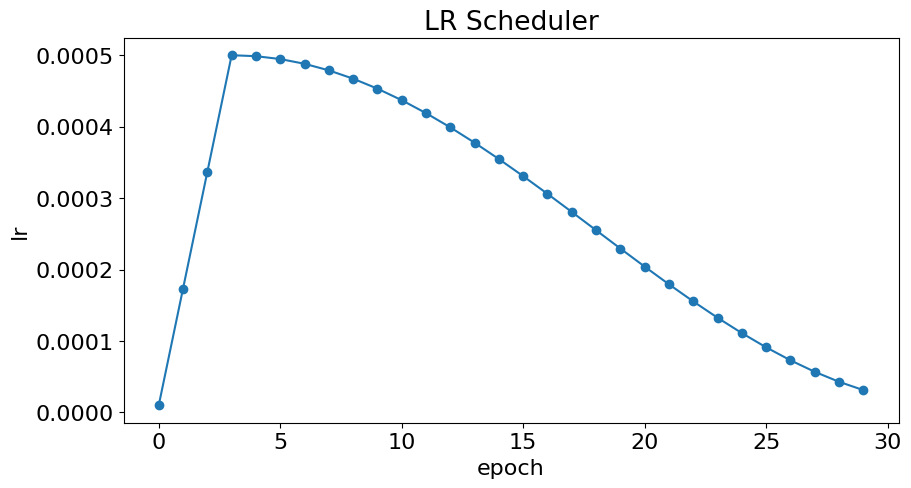

In [ ]:
def get_lr_callback(batch_size=32, mode='cos', epochs=50, plot=False):
    lr_start, lr_max, lr_min = 1e-5, 5e-4, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return tfk.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

lr_cb = get_lr_callback(batch_size, mode='cos', epochs=epochs, plot=True)
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, restore_best_weights=True)
callbacks = [early_stopping, lr_cb]



In [ ]:
# Define optimizer and metric
learning_rate = 1e-5
optimizer = tfk.optimizers.AdamW(learning_rate)
loss = tfk.losses.BinaryCrossentropy()
metrics = ['accuracy','AUC']

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = callbacks
).history

Epoch 1/30
454/454 [==============================] - 263s 536ms/step - loss: 0.6376 - accuracy: 0.6474 - auc: 0.7007 - val_loss: 0.7616 - val_accuracy: 0.5038 - val_auc: 0.7076 - lr: 1.0000e-05
Epoch 2/30
454/454 [==============================] - 239s 527ms/step - loss: 0.6020 - accuracy: 0.6833 - auc: 0.7444 - val_loss: 0.6512 - val_accuracy: 0.6365 - val_auc: 0.7571 - lr: 1.7333e-04
Epoch 3/30
454/454 [==============================] - 239s 527ms/step - loss: 0.5813 - accuracy: 0.7062 - auc: 0.7656 - val_loss: 0.5806 - val_accuracy: 0.7009 - val_auc: 0.7746 - lr: 3.3667e-04
Epoch 4/30
454/454 [==============================] - 238s 524ms/step - loss: 0.5729 - accuracy: 0.7130 - auc: 0.7743 - val_loss: 0.6184 - val_accuracy: 0.6671 - val_auc: 0.7732 - lr: 5.0000e-04
Epoch 5/30
454/454 [==============================] - 239s 525ms/step - loss: 0.5667 - accuracy: 0.7181 - auc: 0.7802 - val_loss: 0.5666 - val_accuracy: 0.7213 - val_auc: 0.7830 - lr: 4.9866e-04
Epoch 6/30
454/454 [=====

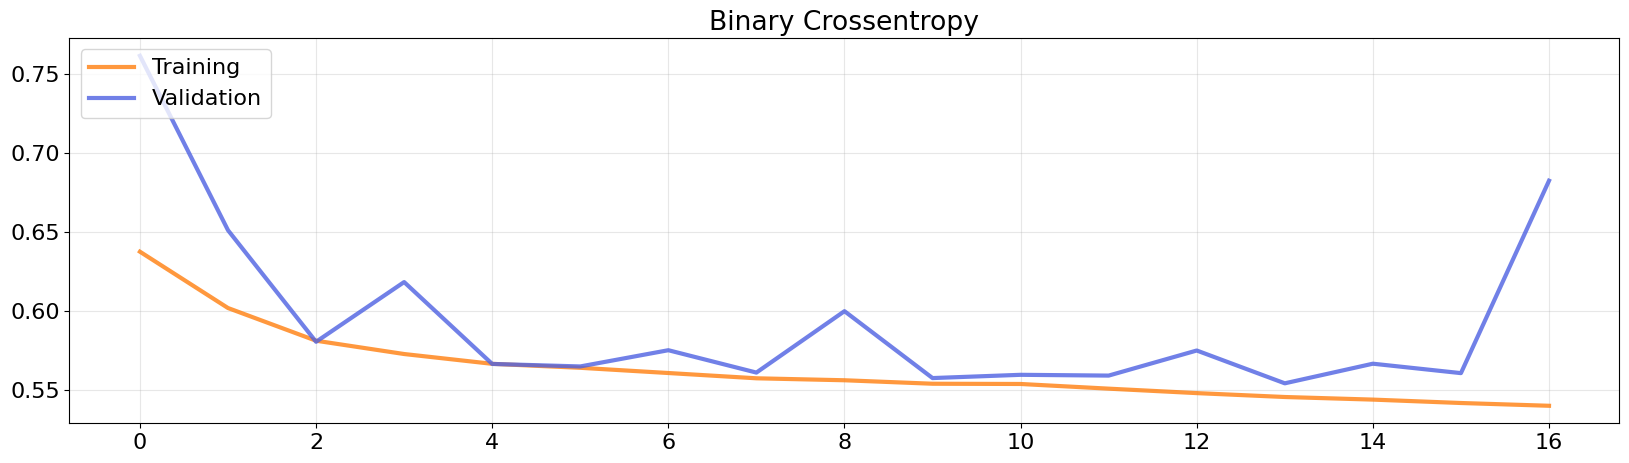

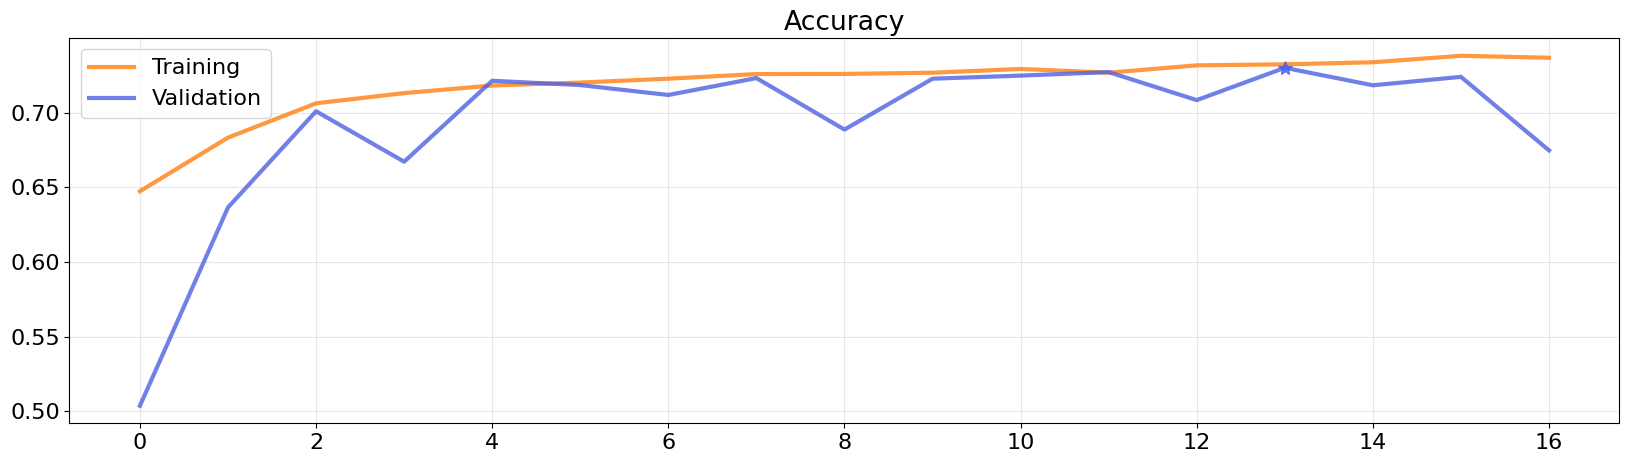

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
save = False

if save:
  model.save('resnet1')

In [ ]:
file_path = 'QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet'
test_generator = CustomDataLoader(file_path, val_idx, batch_size, mean_train, std_train)

In [ ]:
out = model.evaluate(test_generator,steps=len(test_generator))

114/114 [==============================] - 41s 361ms/step - loss: 0.5477 - accuracy: 0.7348 - auc: 0.7968


In [ ]:
del model
del history